## Analyzing full sweep: sub5, n=5

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import lsqfit # WARNING: lsqfit 12.0 appears to be broken. `python3 -m pip install lsqfit==11.8`

from z2_sim.src.NumericsPython.Analysis.fourieranalysis import fourier_ana
from z2_sim.src.QuantumCircuits.Cirq_Code import io

In [2]:
%load_ext autoreload
%autoreload 2

### Composing htcondor results into a single .npy

You won't be able to run this without access to the raw htcondor outputs. Therefore I have commented it out.

In [80]:
# flag = 'obc'
# ns = [3, 4, 5]

# # Submission card
# dt = 0.25
# j_sweep = np.asarray([0.714285, 0.625, .555556])     
# # assert statements never hurt anyone
# j_sweep_control = np.load( os.path.join(noiseless_directory, io.make_physical_params_sweep_fname(noiseless_tag, 'jcoup')))
# assert np.allclose(j_sweep, j_sweep_control, atol=1e-5, rtol=1e-4)

# noisy_directory = './results/noisy'
# beta_sweep = 1 / j_sweep
# assert np.allclose(beta_sweep, [1.4, 1.6, 1.8])
# beta_sweep = [1.4, 1.6, 1.8]
# beta_keys = np.round(beta_sweep, decimals=6)

# # These noise parameters are constant across grid sizes
# zeta_sweep = [0, 150000, 300000, 450000, 600000, 750000]
# tstart = 1
# tstop = 51

# # # Load the data into separate dictionaries that can be passed to `fourier_ana`
# # # This way, any element of this data sequence can be treated on equal footing 
# # # with a noiseless data array.

# for n in ns:
    

#     # These noise parameters change depending on grid
#     if n in [4, 5]:
#         eps_sweep = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
#         n_trajectories = 1000
#         nprocs = 1

#         noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")
#         collector = io.CondorCollector(
#             path=noisy_subdirectory,
#             nprocs=nprocs,
#             n=n,
#             j_sweep=j_sweep,
#             dt_sweep=[dt],
#             trotter_intervals=[(tstart, tstop)],
#             zeta_sweep=zeta_sweep,
#             eps_sweep=eps_sweep,
#             r=n_trajectories,
#         )

#         #!! epsilon dependence stored in the 4th index
#         #!! shot dependence stored in the 0th index
#         data_arr = collector.collect_htcondor_outputs()
        
#     elif n == 3:
#         eps_sweep = [0.001, 0.002, 0.003, 0.004, 0.005]
#         n_trajectories = 100
#         nprocs = 10

#         # Concatenate with the unitary eps=0 data
#         # These are in a particular order. Don't worry about it.
#         noisy_directory = "./results/noisy"
#         noisy_data = {}
#         noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")
#         noisy_tag = "20210921d"
        
#         collector = io.CondorCollector(
#             path=noisy_subdirectory,
#             nprocs=nprocs,
#             n=n,
#             j_sweep=j_sweep,
#             dt_sweep=[dt],
#             trotter_intervals=[(tstart, tstop)],
#             zeta_sweep=zeta_sweep,
#             eps_sweep=eps_sweep, # don't look for eps=0
#             r=n_trajectories,
#         )

#         data_arr = collector.collect_htcondor_outputs()

#         zetas_zeroeps = np.load(os.path.join(noisy_directory, io.make_noisy_params_sweep_fname(noisy_tag, 'zeta')))
#         assert np.allclose(zetas_zeroeps, zeta_sweep)
        
#         noisy_fname = f'noisy_parameter_sweep_{noisy_tag}_results_n{n}_{flag}.npy'
#         zeroeps_data_arr = np.load(os.path.join(noisy_subdirectory, noisy_fname))
#         # yikes yikes yikes
#         data_transpose = np.swapaxes(zeroeps_data_arr, 0, 2)
#         data_transpose = np.swapaxes(data_transpose, 0, 1)
#         temp = np.zeros((nprocs, len(j_sweep),  1, len(zeta_sweep), len(eps_sweep) + 1, tstop - tstart, n, n), dtype=complex)
#         for i in range(nprocs):
#             temp[i,:,:,:,0,:,:,:] = data_transpose
#             temp[i,:,:,:,1:,:,:,:] = data_arr[i]
        
#         data_arr = temp


#     np.save(f"./final/noisy/{n}/n{n}_raw.npy", data_arr)


In [103]:
noiseless_directory = "./final/noiseless"
flag = 'obc'
ns = [3, 4, 5]

# Load the noiseless data into a single dictionary that can be passed to `fourier_ana`
noiseless_data = {}
noiseless_tag = "control"
dts = [0.25]
for n in ns:
    noiseless_subdirectory = os.path.join(noiseless_directory, f"{n}/")
    noiseless_fname = f'noiseless_parameter_sweep_{noiseless_tag}_results_n{n}_{flag}.npy'
    arr = np.load(os.path.join(noiseless_subdirectory, noiseless_fname))[:,:,:50,:,:]
    noiseless_data[(flag, n)] = arr

    
# Submission card
dt = 0.25
j_sweep = np.asarray([0.714285, 0.625, .555556])     
# assert statements never hurt anyone
j_sweep_control = np.load( os.path.join(noiseless_directory, io.make_physical_params_sweep_fname(noiseless_tag, 'jcoup')))
assert np.allclose(j_sweep, j_sweep_control, atol=1e-5, rtol=1e-4)

noisy_directory = './results/noisy'
beta_sweep = 1 / j_sweep
assert np.allclose(beta_sweep, [1.4, 1.6, 1.8])
beta_sweep = [1.4, 1.6, 1.8]
beta_keys = np.round(beta_sweep, decimals=6)

# These noise parameters are constant across grid sizes
zeta_sweep = [0, 150000, 300000, 450000, 600000, 750000]
tstart = 1
tstop = 51
# It was later determined that eps 0.005 was too big for any meaningful results
# Therefore larger grids used a finer epsilon sweep
eps_sweeps = {
    3: [0, 0.001, 0.002, 0.003, 0.004, 0.005],
    4: [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003],
    5: [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003],
}

noisy_data_grids = {}
for n in ns:
    eps_sweep = eps_sweeps.get(n)
    noisy_data_grid = [[{} for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]
    for i in range(len(zeta_sweep)):
        for j in range(len(eps_sweep)):
            data_arr = np.load(f"./final/noisy/{n}/n{n}_raw.npy")
            # (nprocs, len(j_sweep), len(dt_sweep), len(zeta_sweep), len(eps_sweep), trotter_steps, n, n)
            noisy_data_grid[i][j][('obc', n)] = data_arr[:,:,:,i,j,:,:,:].mean(axis=0)
    noisy_data_grids[n] = noisy_data_grid

### Perform the fourier analysis and mass analysis on each dataset

Noiseless datset followed by noisy dataset at each noise parameter.

In [127]:
bc_flags = ['obc']
noiseless_fourier = fourier_ana(
    results=noiseless_data, 
    bc_flags=bc_flags, 
    grid_sizes=ns, 
    dts=dts, 
    betas=beta_sweep, 
    n_trotter=50, 
    samp_rate = 2048, 
    nboot = 200)

noisy_fourier_grids = {}
for n in ns:
    eps_sweep = eps_sweeps.get(n)
    noisy_fourier_grid = [[None for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]
    for i in range(len(zeta_sweep)):
        for j in range(len(eps_sweep)):
            noisy_data = noisy_data_grids.get(n)[i][j]
            noisy_fourier = fourier_ana(
                results=noisy_data, 
                bc_flags=bc_flags, 
                grid_sizes=[n], 
                dts=dts, 
                betas=beta_sweep, 
                n_trotter=50, 
                samp_rate = 2048, 
                nboot = 200
            )
            noisy_fourier_grid[i][j] = noisy_fourier
    noisy_fourier_grids[n] = noisy_fourier_grid


In [128]:
# This is how you access a time series given (n, dt, beta, zeta, eps, x, y)
noisy_data_grids.get(4)[-1][2][('obc', 4)][2, 0,:,1,1].real

array([-0.00313195, -0.0140401 , -0.00889023,  0.00958334,  0.04327429,
        0.08768824,  0.08817755,  0.06185653,  0.0596467 ,  0.04141092,
       -0.02103299, -0.05503535, -0.0632517 , -0.05312574, -0.02602391,
        0.00027676,  0.02955145,  0.04811691,  0.055523  ,  0.05487563,
        0.04714958,  0.0395172 ,  0.03993411,  0.03976699,  0.04128091,
        0.04201335,  0.04095262,  0.03817335,  0.03462992,  0.02742291,
        0.02026371,  0.01384611,  0.01048477,  0.01076399,  0.01380767,
        0.01546266,  0.01824062,  0.01967485,  0.02085831,  0.02171018,
        0.02196867,  0.02095987,  0.02029525,  0.01850235,  0.01839111,
        0.01592567,  0.01629693,  0.01583654,  0.01531071,  0.01478879])

## Bulk analysis

This is mostly to cross reference with the individual results I got in different notebooks and confirm that I did the stitching correctly.

In [129]:
dt = 0.25
noisy_mass_grids = {}
noisy_mass_err_grids = {}
for n in ns:
    eps_sweep = eps_sweeps.get(n)
    noisy_mass_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))
    noisy_mass_err_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))
    for i, betakey in enumerate(beta_keys):

        # Plot noiseless energy vs dt
#         ens = noiseless_fourier[1]
#         noiseless_y = np.abs(np.array(gv.mean(ens[('obc', n, dt, betakey)])))
#         noiseless_yerr = gv.sdev(ens[('obc', n, dt, betakey)])
#         noisy_mass_grid[i,j,k,0] = noiseless_y
#         noisy_mass_grid[i,j,k,1] = noiseless_yerr
        
        for j, zeta in enumerate(zeta_sweep):
            for k, eps in enumerate(eps_sweep):
                ens_noisy = noisy_fourier_grids.get(n)[j][k][1]

                # Compute and plot absolute error
                noisy_y = np.abs(np.array(gv.mean(ens_noisy[('obc', n, dt, betakey)])))
                noisy_yerr = gv.sdev(ens_noisy[('obc', n, dt, betakey)])
                print(noisy_y, " ", noisy_yerr)
                noisy_mass_grid[i,j,k] = noisy_y
                noisy_mass_err_grid[i,j,k] = noisy_yerr
                
    noisy_mass_grids[n] = noisy_mass_grid
    noisy_mass_err_grids[n] = noisy_mass_err_grid

                

1.3823007675795085   0.12566370614359174
1.3823007675795085   0.12566370614359174
2.0904157516986484   2.0913920897092604
4.248689904714836   2.6519326722923595
3.7554598581012386   2.814731743557344
4.117371331794782   2.7221490464852036
1.3823007675795085   0.12566370614359174
1.3540264336972008   0.17657315850106228
2.3279201563100367   2.628893667726865
4.413309359762941   2.6755913089799
4.373096973796992   2.7269603322430607
4.307123528071607   2.76793924753381
1.3823007675795085   0.12566370614359174
0.40966368202810904   0.3924330872109208
1.6273449945595126   2.490226969349352
3.9445837358473437   2.8820797726219225
4.205335926095297   2.8064922427571277
3.724043931565341   2.944479967091752
0.25132741228718336   0.12566370614359174
0.25132741228718336   0.12566370614359174
1.3025043141783283   2.2752481124705235
3.9672032029531907   2.8874093519381896
3.9401855061323188   2.9140949459851995
3.777451006676367   2.933881287963493
0.25132741228718336   0.12566370614359174
0.2513

0.3864158963915446   0.12566370614359174
0.3776194369614931   0.12845849047239097
0.3958406743523139   0.12566370614359174
0.4197167785195964   0.4260425909749053
0.41469023027385277   0.4276260403008493
0.43793801591041714   0.43166489089915877
0.35311501426349273   0.12566370614359174
0.36945129606215965   0.1351337738948764
0.3977256299444678   0.13345077356651658
0.40777872643595514   0.12566370614359174
0.40400881525164734   0.1286918449988343
0.4197167785195964   0.13146129502816983
0.40400881525164734   0.1432111473651396
0.2651504199629785   0.12566370614359174
0.40777872643595514   0.16360309395478526
0.40400881525164734   0.14321114736513957
0.4303981935418017   0.14074194837711443
0.4266282823574939   0.12931613554784943
0.4643273942005714   0.4243262568187094
0.4259999638267759   0.1431628977196194
0.4329114676646735   0.18920527027399442
0.44359288268687874   0.1740839236971896
0.4442212012175968   0.14042743456160045
0.44673447534046856   0.1304105345429622
0.432283149133

In [132]:
for n in ns:
    noisy_mass_grid = noisy_mass_grids.get(n)
    noisy_mass_err_grid = noisy_mass_err_grids.get(n)
    np.save(f"n{n}_noisy_masses.npy", noisy_mass_grid)
    np.save(f"n{n}_noisy_mass_err.npy", noisy_mass_grid)
    

0.43166489089915877

In [133]:
rel_err_grids = {}
for n in ns:
    eps_sweep = eps_sweeps.get(n)
    rel_err_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))

    for i, betakey in enumerate(beta_keys):
        zero_noise_mass = noisy_mass_grids.get(n)[i,0,0]
        rel_err_grid[i] = (noisy_mass_grids.get(n)[i] - zero_noise_mass) / zero_noise_mass
    rel_err_grids[n] = rel_err_grid

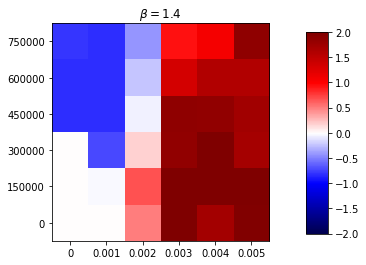

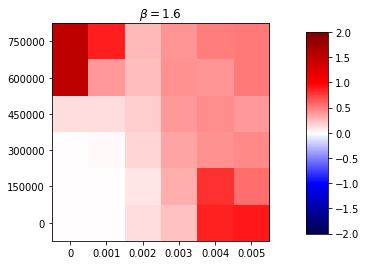

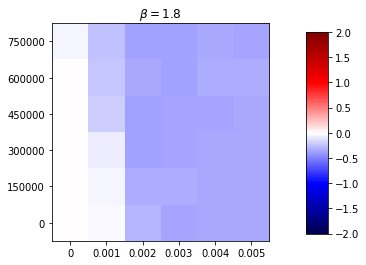

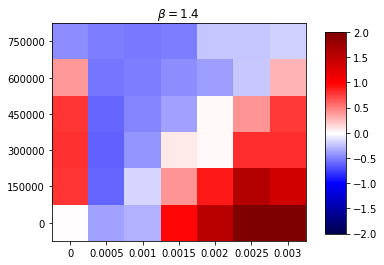

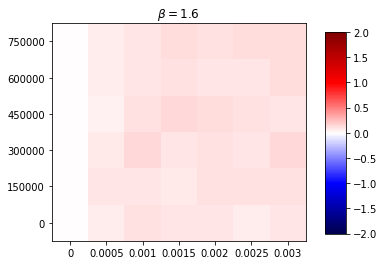

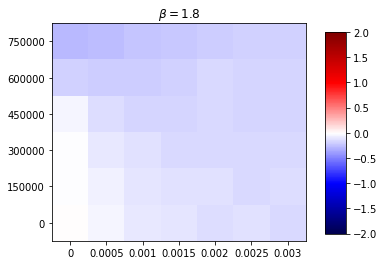

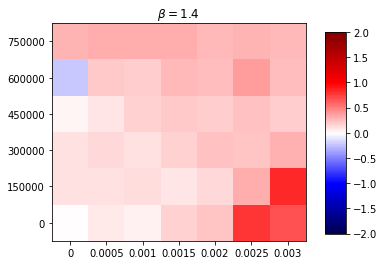

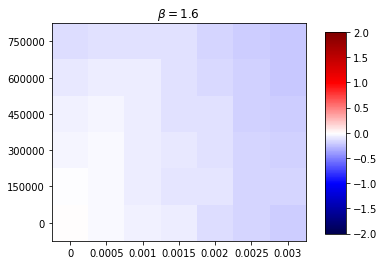

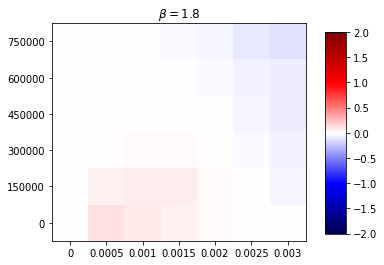

In [134]:
# Compute the relative errors


for n in ns:
    for i, beta in enumerate(beta_sweep):
        fig, ax = plt.subplots()
        eps_sweep = eps_sweeps.get(n)

        im = ax.imshow(rel_err_grids.get(n)[i], cmap="seismic", vmin=-2, vmax=2, origin='lower')
        ax.set_title(r"$\beta=$" + f"{beta}")
        ax.set_xticks(range(len(eps_sweep)))
        ax.set_xticklabels(eps_sweep)
        ax.set_yticks(range(len(zeta_sweep)))
        ax.set_yticklabels(zeta_sweep)

        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)